In [1]:
import numpy as np
import numpy.random as rng
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Generate X

In [2]:
p = 200
N = 50
rho = 0

In [81]:
Sigma = np.ones((p, p)) * rho
Sigma = Sigma + np.diag(np.ones(p) * (1-rho))
X = rng.multivariate_normal(np.zeros(p), Sigma, N)
X = X - np.mean(X, axis=0)
X = X * np.sqrt(N / np.sum(X**2, axis=0))

In [ ]:
np.save('./data/X_rho09_N50_p200', X)

In [3]:
X = np.load('./data/X_rho0_N50_p200.npy')

In [4]:
X.T @ X / 50

array([[ 1.        , -0.22317435,  0.07571759, ..., -0.15341889,
         0.00907804, -0.13277991],
       [-0.22317435,  1.        ,  0.14187555, ...,  0.2386463 ,
         0.00484868,  0.26406071],
       [ 0.07571759,  0.14187555,  1.        , ..., -0.02874032,
         0.10405781,  0.18162737],
       ...,
       [-0.15341889,  0.2386463 , -0.02874032, ...,  1.        ,
        -0.17354178, -0.14627226],
       [ 0.00907804,  0.00484868,  0.10405781, ..., -0.17354178,
         1.        ,  0.0655425 ],
       [-0.13277991,  0.26406071,  0.18162737, ..., -0.14627226,
         0.0655425 ,  1.        ]])

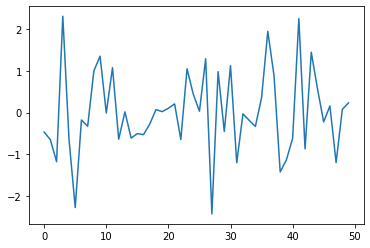

In [84]:
plt.plot(X[:,0])
plt.show()

In [33]:
class Generator(object):
    def __init__(self, p, theta, beta_range, N, X, cat_XtY=False) -> None:
        self.p = p
        self.theta = theta
        self.beta_range = beta_range
        self.N = N
        self.X = X
        self.cat_XtY = cat_XtY
        self.normalize_c = 1.

    def generate_samples(self, n):
        scale = self.beta_range[1] - self.beta_range[0]
        # every beta has the same theta
        theta = np.ones((n, self.p)) * self.theta
        gamma = rng.binomial(1, theta)
        beta = np.zeros((n, self.p))
        beta[gamma == 1] = rng.rand(
            np.sum(gamma == 1)) * scale + self.beta_range[0]
        beta[gamma == 0] = 0.
        Y = beta@self.X.T + rng.randn(n, self.N)
        if self.cat_XtY:
            Y = np.concatenate((Y, Y @ self.X), axis=1)
        return gamma, beta, Y/self.normalize_c


class MLP(nn.Module):
    def __init__(self, N, p, t=0):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()
        self.hshrink = nn.Hardshrink(t)
        self.sshrink = nn.Softshrink(t)
        self.tshrink = nn.Tanhshrink()

    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        u = self.relu(self.fc3(u))
        u = self.relu(self.fc4(u))
        output = self.tshrink(self.fc5(u))
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss


def train_epoch_with_generator(model, optimizer, generator, batch_size, iteration, bceloss=False, subset=0):
    train_loss = 0.
    for i in range(iteration):
        gamma, beta, Y = generator.generate_samples(batch_size)
        gamma = torch.from_numpy(gamma).type(torch.float).to(device)
        beta = torch.from_numpy(beta).type(torch.float).to(device)
        Y = torch.from_numpy(Y).type(torch.float).to(device)
        if subset != 0:
            beta = beta[:, :subset]
            gamma = gamma[:, :subset]
        if bceloss:
            loss = model.get_bceloss(Y, gamma)
        else:
            loss = model.get_mseloss(Y, beta)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/(i+1)


def model_test(model, test_data, test_label, bceloss=False):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(test_data).type(torch.float).to(device)
        targ = torch.from_numpy(test_label).type(torch.float).to(device)
        if bceloss:
            loss = model.get_bceloss(data, targ)
        else:
            loss = model.get_mseloss(data, targ)
    return loss.item()


def train_model_with_generator(model, generator, lr, batch_size, epochs, iter_per_epoch, bceloss=False, subset=0, val_data=None, val_label=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for i in range(epochs):
        model.train()
        train_loss = train_epoch_with_generator(
            model, optimizer, generator, batch_size, iter_per_epoch, bceloss, subset)
        print('Epoch: {}, Loss: {:.5f}'.format(i+1, train_loss))
        train_losses.append(train_loss)
        if isinstance(val_data, np.ndarray):
            val_loss = model_test(model, val_data, val_label, bceloss)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
    return train_losses, val_losses

In [6]:
theta = 0.05
beta_range = (-3, 3)
generator = Generator(p, theta, beta_range, N, X, cat_XtY=True)

In [12]:
gamma_val, beta_val, Y_val = generator.generate_samples(10000)

In [43]:
np.save('./data/gamma_val_rho06', gamma_val)
np.save('./data/beta_val_rho06', beta_val)
np.save('./data/Y_val_rho06',Y_val)
np.save('./data/normalize_constant_rho06', np.array([900.]))

In [7]:
gamma_val = np.load('./data/gamma_val_rho0.npy')
beta_val = np.load('./data/beta_val_rho0.npy')
Y_val = np.load('./data/Y_val_rho0.npy')
normalize_c = np.load('./data/normalize_constant_rho0.npy')

In [14]:
np.max(np.abs(Y_val))

318.2954368469232

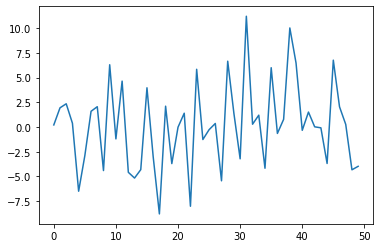

In [39]:
plt.plot(Y_val[2,:50])

In [8]:
generator.normalize_c = normalize_c
generator.normalize_c

array([350.])

In [34]:
model = MLP(N+p, p).to(device)

In [21]:
normalize_c

318.2954368469232

In [37]:
train_losses, val_losses = train_model_with_generator(model, generator, 0.001, 256, 25, 3000, val_data=Y_val/normalize_c, val_label=beta_val)

Epoch: 1, Loss: 0.04288
Val loss: 0.04263
Epoch: 2, Loss: 0.04183
Val loss: 0.04153
Epoch: 3, Loss: 0.04103
Val loss: 0.04059
Epoch: 4, Loss: 0.04038
Val loss: 0.04005
Epoch: 5, Loss: 0.03986
Val loss: 0.03942
Epoch: 6, Loss: 0.03925
Val loss: 0.03898
Epoch: 7, Loss: 0.03877
Val loss: 0.03874
Epoch: 8, Loss: 0.03819
Val loss: 0.03800
Epoch: 9, Loss: 0.03786
Val loss: 0.03773
Epoch: 10, Loss: 0.03750
Val loss: 0.03694
Epoch: 11, Loss: 0.03700
Val loss: 0.03687
Epoch: 12, Loss: 0.03676
Val loss: 0.03637
Epoch: 13, Loss: 0.03643
Val loss: 0.03632
Epoch: 14, Loss: 0.03616
Val loss: 0.03581
Epoch: 15, Loss: 0.03596
Val loss: 0.03576
Epoch: 16, Loss: 0.03571
Val loss: 0.03565
Epoch: 17, Loss: 0.03559
Val loss: 0.03536
Epoch: 18, Loss: 0.03538
Val loss: 0.03497
Epoch: 19, Loss: 0.03526
Val loss: 0.03503
Epoch: 20, Loss: 0.03508
Val loss: 0.03473
Epoch: 21, Loss: 0.03492
Val loss: 0.03489
Epoch: 22, Loss: 0.03482
Val loss: 0.03474
Epoch: 23, Loss: 0.03481
Val loss: 0.03465
Epoch: 24, Loss: 0.0

In [35]:
model.eval()
with torch.no_grad():
    print(model(torch.from_numpy(Y_val[0]/normalize_c).type(torch.float).to(device)))

tensor([ 1.6414e-05, -1.5134e-07, -2.5611e-07,  7.2513e-06,  3.3304e-06,
        -2.0981e-05,  3.3751e-06, -4.8429e-08, -8.8476e-09,  9.0338e-08,
         4.9546e-07, -1.0161e-06, -6.5658e-07, -1.1567e-06, -3.4217e-06,
         8.1491e-10,  1.2573e-08, -1.6224e-06, -1.0291e-06,  6.4336e-06,
         5.0385e-06,  6.8713e-06, -3.0454e-07,  1.0822e-05,  4.4815e-06,
         3.2317e-06, -2.1253e-06,  1.1632e-06,  1.6481e-05, -6.1467e-06,
         4.3679e-06, -2.7847e-07, -1.0516e-05,  5.3551e-08, -4.4424e-07,
        -2.7400e-06, -1.4622e-06,  1.6764e-07, -6.3423e-07, -1.3039e-08,
        -1.0589e-06,  2.5947e-06, -6.1262e-06, -6.3702e-07,  1.0012e-07,
        -1.7211e-06, -7.2867e-06, -4.1071e-06,  1.8347e-06, -8.5775e-07,
        -2.4941e-06,  9.1419e-06,  2.3935e-07, -2.1867e-06, -1.6298e-07,
         1.8533e-07,  3.1665e-08, -5.8208e-11, -5.8208e-10, -7.2643e-08,
        -3.0864e-06,  1.8012e-06,  5.4482e-08, -2.4959e-07, -3.2969e-07,
        -6.0536e-09, -1.8394e-08, -4.0215e-06,  1.2

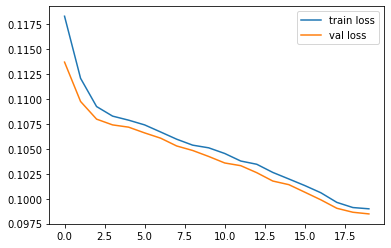

In [42]:
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(train_losses)), val_losses)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

In [14]:
model.eval()
model(torch.from_numpy(Y_val[0,]).type(torch.float).to(device))

tensor([-2.1356e-03, -1.9509e-03,  8.6315e-04,  2.7134e-03,  2.2696e-03,
         2.0534e-03, -2.3864e-03,  9.1116e-04,  1.1884e-03, -3.6927e-04,
         5.3413e-03, -7.7877e-04,  1.1247e-03, -3.5897e-03, -1.9135e-03,
        -3.6004e-04,  3.4093e-03,  1.5913e-03, -3.0593e-03,  5.5612e-04,
        -2.7383e-04, -7.2972e-05,  2.9570e-03,  3.0879e-04, -3.7354e-03,
         5.8934e-03,  1.3556e-03,  2.4641e-03,  9.9242e-04,  6.6320e-03,
         2.9021e-03,  6.1032e-04, -5.4758e-04, -2.7579e-04, -3.7908e-03,
         1.2188e-03,  3.2247e-03, -4.5735e-03, -1.6367e-03,  2.9071e-03,
        -2.4446e-03,  5.0206e-03,  1.1308e-03,  3.4796e-03, -2.9448e-03,
        -1.6018e-03,  6.0706e-04,  3.9783e-03,  7.6741e-04, -3.4235e-03,
        -9.4673e-04, -3.1079e-04,  8.4942e-04, -7.1194e-04,  2.0698e-03,
         4.5115e-03,  1.4267e-03,  3.8891e-03,  2.0673e-04, -6.6604e-04,
         2.5294e-03,  4.9518e-04,  4.0886e-04,  2.7636e-03,  8.8944e-03,
        -4.3159e-03,  8.4544e-04,  2.0263e-04,  9.0

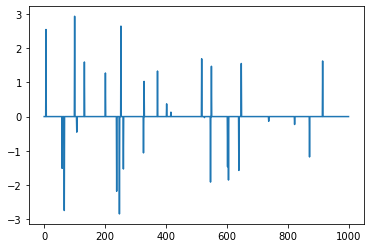

In [15]:
plt.plot(beta_val[0,])
plt.show()

In [25]:
class MLP_sigmoid(nn.Module):
    def __init__(self, N, p):
        super(MLP_sigmoid, self).__init__()

        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.sigmoid = nn.Sigmoid()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()

    def forward(self, input):
        u = self.sigmoid(self.fc1(input))
        u = self.sigmoid(self.fc2(u))
        u = self.sigmoid(self.fc3(u))
        u = self.sigmoid(self.fc4(u))
        output = self.fc5(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss

In [26]:
model_sigmoid = MLP_sigmoid(N+p, p).to(device)
train_losses, val_losses = train_model_with_generator(model_sigmoid, generator, 0.001, 256, 20, 1000, val_data=Y_val/normalize_c, val_label=beta_val)

Epoch: 1, Loss: 0.06024
Val loss: 0.06010
Epoch: 2, Loss: 0.06002
Val loss: 0.06010
Epoch: 3, Loss: 0.06004
Val loss: 0.06010
Epoch: 4, Loss: 0.06003
Val loss: 0.06010
Epoch: 5, Loss: 0.05994
Val loss: 0.06010
Epoch: 6, Loss: 0.06001
Val loss: 0.06010
Epoch: 7, Loss: 0.05997
Val loss: 0.06010
Epoch: 8, Loss: 0.05995
Val loss: 0.06010
Epoch: 9, Loss: 0.05998
Val loss: 0.06010
Epoch: 10, Loss: 0.06001
Val loss: 0.06010
Epoch: 11, Loss: 0.06003
Val loss: 0.06010
Epoch: 12, Loss: 0.05999
Val loss: 0.06010
Epoch: 13, Loss: 0.06001
Val loss: 0.06010
Epoch: 14, Loss: 0.06001
Val loss: 0.06010
Epoch: 15, Loss: 0.06000
Val loss: 0.06010
Epoch: 16, Loss: 0.05996
Val loss: 0.06010
Epoch: 17, Loss: 0.05999
Val loss: 0.06010
Epoch: 18, Loss: 0.05997
Val loss: 0.06010
Epoch: 19, Loss: 0.06005
Val loss: 0.06010
Epoch: 20, Loss: 0.06001
Val loss: 0.06010


In [27]:
model_subset = MLP(N+p, 10)
model_subset.to(device)

MLP(
  (fc1): Linear(in_features=1100, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=10, bias=True)
  (relu): ReLU()
  (mseloss): MSELoss()
  (bceloss): BCEWithLogitsLoss()
)

In [29]:
train_losses, val_losses = train_model_with_generator(model_subset, generator, 0.001, 256, 20, 1000, subset=10, val_data=Y_val/normalize_c, val_label=beta_val[:,:10])

Epoch: 1, Loss: 0.03806
Val loss: 0.03818
Epoch: 2, Loss: 0.03780
Val loss: 0.03741
Epoch: 3, Loss: 0.03738
Val loss: 0.03695
Epoch: 4, Loss: 0.03710
Val loss: 0.03689
Epoch: 5, Loss: 0.03723
Val loss: 0.03690
Epoch: 6, Loss: 0.03688
Val loss: 0.03710
Epoch: 7, Loss: 0.03712
Val loss: 0.03683
Epoch: 8, Loss: 0.03630
Val loss: 0.03646
Epoch: 9, Loss: 0.03685
Val loss: 0.03651
Epoch: 10, Loss: 0.03671
Val loss: 0.03598
Epoch: 11, Loss: 0.03607
Val loss: 0.03620
Epoch: 12, Loss: 0.03654
Val loss: 0.03624
Epoch: 13, Loss: 0.03634
Val loss: 0.03644
Epoch: 14, Loss: 0.03588
Val loss: 0.03596
Epoch: 15, Loss: 0.03617
Val loss: 0.03623
Epoch: 16, Loss: 0.03580
Val loss: 0.03645
Epoch: 17, Loss: 0.03581
Val loss: 0.03650
Epoch: 18, Loss: 0.03597
Val loss: 0.03584
Epoch: 19, Loss: 0.03563
Val loss: 0.03620
Epoch: 20, Loss: 0.03594
Val loss: 0.03553


In [34]:
true_beta = np.zeros((1000,1))
true_beta[:4,0]=2
Y_obs = X @ true_beta + rng.randn(100, 1)
input = np.concatenate((Y_obs, X.T @ Y_obs), axis=0) / normalize_c
model_subset.eval()
input = torch.from_numpy(input.reshape(-1)).type(torch.float).to(device)
model_subset(input)

tensor([ 0.7636,  0.3573,  0.3093,  1.4648, -0.0185,  0.0293,  0.0206, -0.1045,
         0.0311, -0.0633], device='cuda:0', grad_fn=<AddBackward0>)

In [35]:
true_beta = np.zeros((1000,1))
true_beta[:6,0]=2
Y_obs = X @ true_beta + rng.randn(100, 1)
input = np.concatenate((Y_obs, X.T @ Y_obs), axis=0) / normalize_c
model_subset.eval()
input = torch.from_numpy(input.reshape(-1)).type(torch.float).to(device)
model_subset(input)

tensor([ 0.0488, -0.0012,  0.1015,  1.1748,  0.0181,  0.1344, -0.0403, -0.0711,
         0.0927, -0.0234], device='cuda:0', grad_fn=<AddBackward0>)

In [11]:
def count_parameters(model):
    return sum(m.numel() for m in model.parameters() if m.requires_grad)

In [37]:
count_parameters(model)

10546152

In [12]:
class MLP_promax(nn.Module):
    def __init__(self, N, p):
        super(MLP_promax, self).__init__()

        self.fc1 = nn.Linear(N, 2048)
        self.fc2 = nn.Linear(2048, 4096)
        self.fc3 = nn.Linear(4096, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()

    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        u = self.relu(self.fc3(u))
        u = self.relu(self.fc4(u))
        output = self.fc5(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss

In [13]:
model_promax = MLP_promax(N+p, p)
count_parameters(model_promax)

22161384

In [14]:
model_promax.to(device)
train_losses, val_losses = train_model_with_generator(model_promax, generator, 0.001, 256, 10, 1000, val_data=Y_val/normalize_c, val_label=beta_val)

Epoch: 1, Loss: 0.05605
Val loss: 0.05462
Epoch: 2, Loss: 0.05463
Val loss: 0.05448
Epoch: 3, Loss: 0.05461
Val loss: 0.05446
Epoch: 4, Loss: 0.05454
Val loss: 0.05445
Epoch: 5, Loss: 0.05452
Val loss: 0.05443
Epoch: 6, Loss: 0.05457
Val loss: 0.05438
Epoch: 7, Loss: 0.05448
Val loss: 0.05433
Epoch: 8, Loss: 0.05441
Val loss: 0.05428
Epoch: 9, Loss: 0.05440
Val loss: 0.05423
Epoch: 10, Loss: 0.05427
Val loss: 0.05418
